# Intelligent Data Analysis and Machine Learning I
## Exam: Creditworthiness (Project 4)

**Lamia Islam**  
lamia.islam@uni-potsdam.de  
Matrikel Nr. **822947**

## Problem Setting

This is a **supervised binary classification problem**. We have labeled training data where the creditworthiness outcome is known (1 = creditworthy, 2 = not creditworthy).

### Input Space
- **Feature vector**: $\mathbf{x} \in \mathbb{R}^d$ where $d = 20$ features
- **Input space**: $\mathcal{X} = \mathbb{R}^d$ (mixed categorical and numerical features)
- **Features include**: checking account status, duration, credit history, purpose, credit amount, savings, employment, installment rate, personal status, debtors, residence time, property, age, installment plans, housing, existing credits, job, dependents, telephone, foreign worker status

### Output Space
- **Target variable**: $y \in \{1, 2\}$ where:
  - $y = 1$: creditworthy
  - $y = 2$: not creditworthy

### Dataset Overview
- **Dataset**: $\mathcal{D} = \{(\mathbf{x}_i, y_i)\}_{i=1}^{1000}$ where $n = 1000$ samples
- **Missing values**: Present in features "Purpose", "Present employment since", "Job", and "Foreign worker" (denoted as "?" in the data)

### Cost Matrix

$$C = \begin{pmatrix}
0 & 1 \\
5 & 0
\end{pmatrix}$$

Where:
- $C(1,2) = 1$: Cost of predicting "not creditworthy" when actual is "creditworthy"
- $C(2,1) = 5$: Cost of predicting "creditworthy" when actual is "not creditworthy" (5× more expensive)
- $C(i,i) = 0$: No cost for correct predictions

### Objective
Find $f: \mathcal{X} \rightarrow \{1, 2\}$ that minimizes the expected cost:

$$f^* = \arg\min_{f} \mathbb{E}_{(\mathbf{x},y) \sim P(\mathbf{X},Y)}[C(y, f(\mathbf{x}))]$$




In [43]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# others
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#different learning libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix, f1_score, recall_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, make_scorer
from sklearn.metrics import RocCurveDisplay

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

## Data Loading

In [44]:
# Define feature names based on German Credit Dataset documentation
feature_names = [
    'checking_account',    # Status of existing checking account
    'duration',           # Duration in months
    'credit_history',     # Credit history
    'purpose',            # Purpose of credit
    'credit_amount',      # Credit amount
    'savings_account',    # Savings account/bonds
    'employment',         # Present employment since
    'installment_rate',   # Installment rate in percentage of disposable income
    'personal_status',    # Personal status and sex
    'other_debtors',      # Other debtors/guarantors
    'residence_since',    # Present residence since
    'property',           # Property
    'age',               # Age in years
    'other_installments', # Other installment plans
    'housing',           # Housing
    'existing_credits',   # Number of existing credits at this bank
    'job',               # Job
    'dependents',        # Number of people liable to provide maintenance for
    'telephone',         # Telephone
    'foreign_worker',    # Foreign worker
    'target'             # Target variable (1=good, 2=bad)
]

# Load the dataset
data = pd.read_csv('kredit.dat', sep='\t', header=None, names=feature_names)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   checking_account    1000 non-null   object
 1   duration            1000 non-null   int64 
 2   credit_history      1000 non-null   object
 3   purpose             1000 non-null   object
 4   credit_amount       1000 non-null   int64 
 5   savings_account     1000 non-null   object
 6   employment          1000 non-null   object
 7   installment_rate    1000 non-null   int64 
 8   personal_status     1000 non-null   object
 9   other_debtors       1000 non-null   object
 10  residence_since     1000 non-null   int64 
 11  property            1000 non-null   object
 12  age                 1000 non-null   int64 
 13  other_installments  1000 non-null   object
 14  housing             1000 non-null   object
 15  existing_credits    1000 non-null   int64 
 16  job                 1000 

,checking_account,duration,credit_history,purpose,credit_amount,savings_account,employment,installment_rate,personal_status,other_debtors,...,property,age,other_installments,housing,existing_credits,job,dependents,telephone,foreign_worker,target
0,A14,36,A32,?,2299,A63,?,4,A93,A101,...,A123,39,A143,A152,1,A173,1,A191,?,1
1,A12,18,A32,A46,1239,A65,A73,4,A93,A101,...,A124,61,A143,A153,1,?,1,A191,A201,1
2,A13,24,A32,A40,947,A61,A74,4,A93,A101,...,A124,38,A141,A153,1,?,2,A191,?,2
3,A14,15,A33,A43,1478,A61,A73,4,A94,A101,...,A121,33,A141,A152,2,A173,1,A191,A201,1
4,A14,24,A32,A40,1525,A64,A74,4,A92,A101,...,A123,34,A143,A152,1,A173,2,A192,A201,1


## Missing Value Analysis

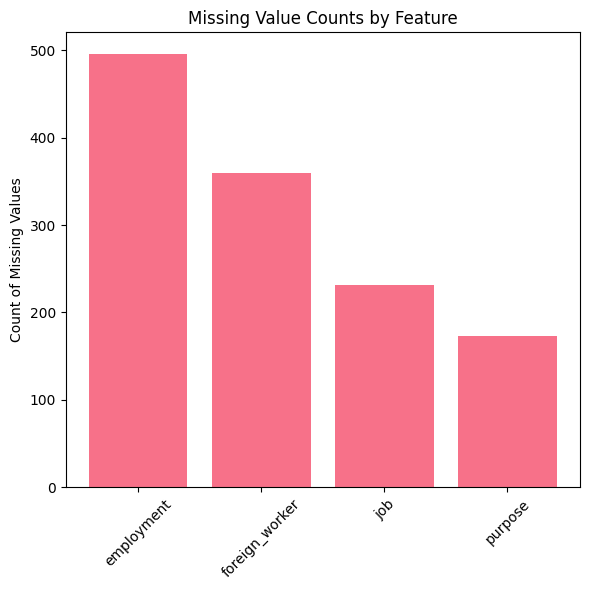

,Feature,Missing_Count,Data_Type
employment,employment,496,object
foreign_worker,foreign_worker,360,object
job,job,232,object
purpose,purpose,173,object


In [45]:
# Identify missing values (marked as '?')
missing_df = pd.DataFrame({
    'Feature': data.columns,
    'Missing_Count': [sum(data[col] == '?') for col in data.columns],
    'Data_Type': data.dtypes
})

missing_df = missing_df.sort_values('Missing_Count', ascending=False)

# Visualize missing values
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))

# Missing value counts
missing_features = missing_df[missing_df['Missing_Count'] > 0]
ax1.bar(missing_features['Feature'], missing_features['Missing_Count'])
ax1.set_title('Missing Value Counts by Feature')
ax1.set_ylabel('Count of Missing Values')
ax1.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
missing_features

## Target Variable Analysis

Target Variable Distribution:
Creditworthy (1): 700
Not Creditworthy (2): 300


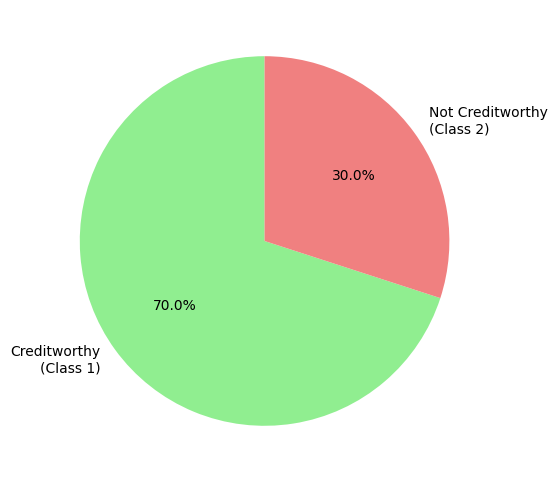

In [46]:
# Analyze target distribution
target_counts = data['target'].value_counts()

print("Target Variable Distribution:")
print(f"Creditworthy (1): {target_counts[1]}")
print(f"Not Creditworthy (2): {target_counts[2]}")

# Visualize target distribution
plt.figure(figsize=(6, 6))
labels = ['Creditworthy\n(Class 1)', 'Not Creditworthy\n(Class 2)']
plt.pie(target_counts.values, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightcoral'])
plt.show()

## Feature Distribution Analysis

In [47]:
# Identify numerical and categorical features
numerical_features = [col for col in data.columns if data[col].dtype == 'int64']
categorical_features = [col for col in data.columns if data[col].dtype == 'object']

print(f"Numerical features ({len(numerical_features)}): {numerical_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

Numerical features (8): ['duration', 'credit_amount', 'installment_rate', 'residence_since', 'age', 'existing_credits', 'dependents', 'target']
Categorical features (13): ['checking_account', 'credit_history', 'purpose', 'savings_account', 'employment', 'personal_status', 'other_debtors', 'property', 'other_installments', 'housing', 'job', 'telephone', 'foreign_worker']


## Visualize numerical feature distributions

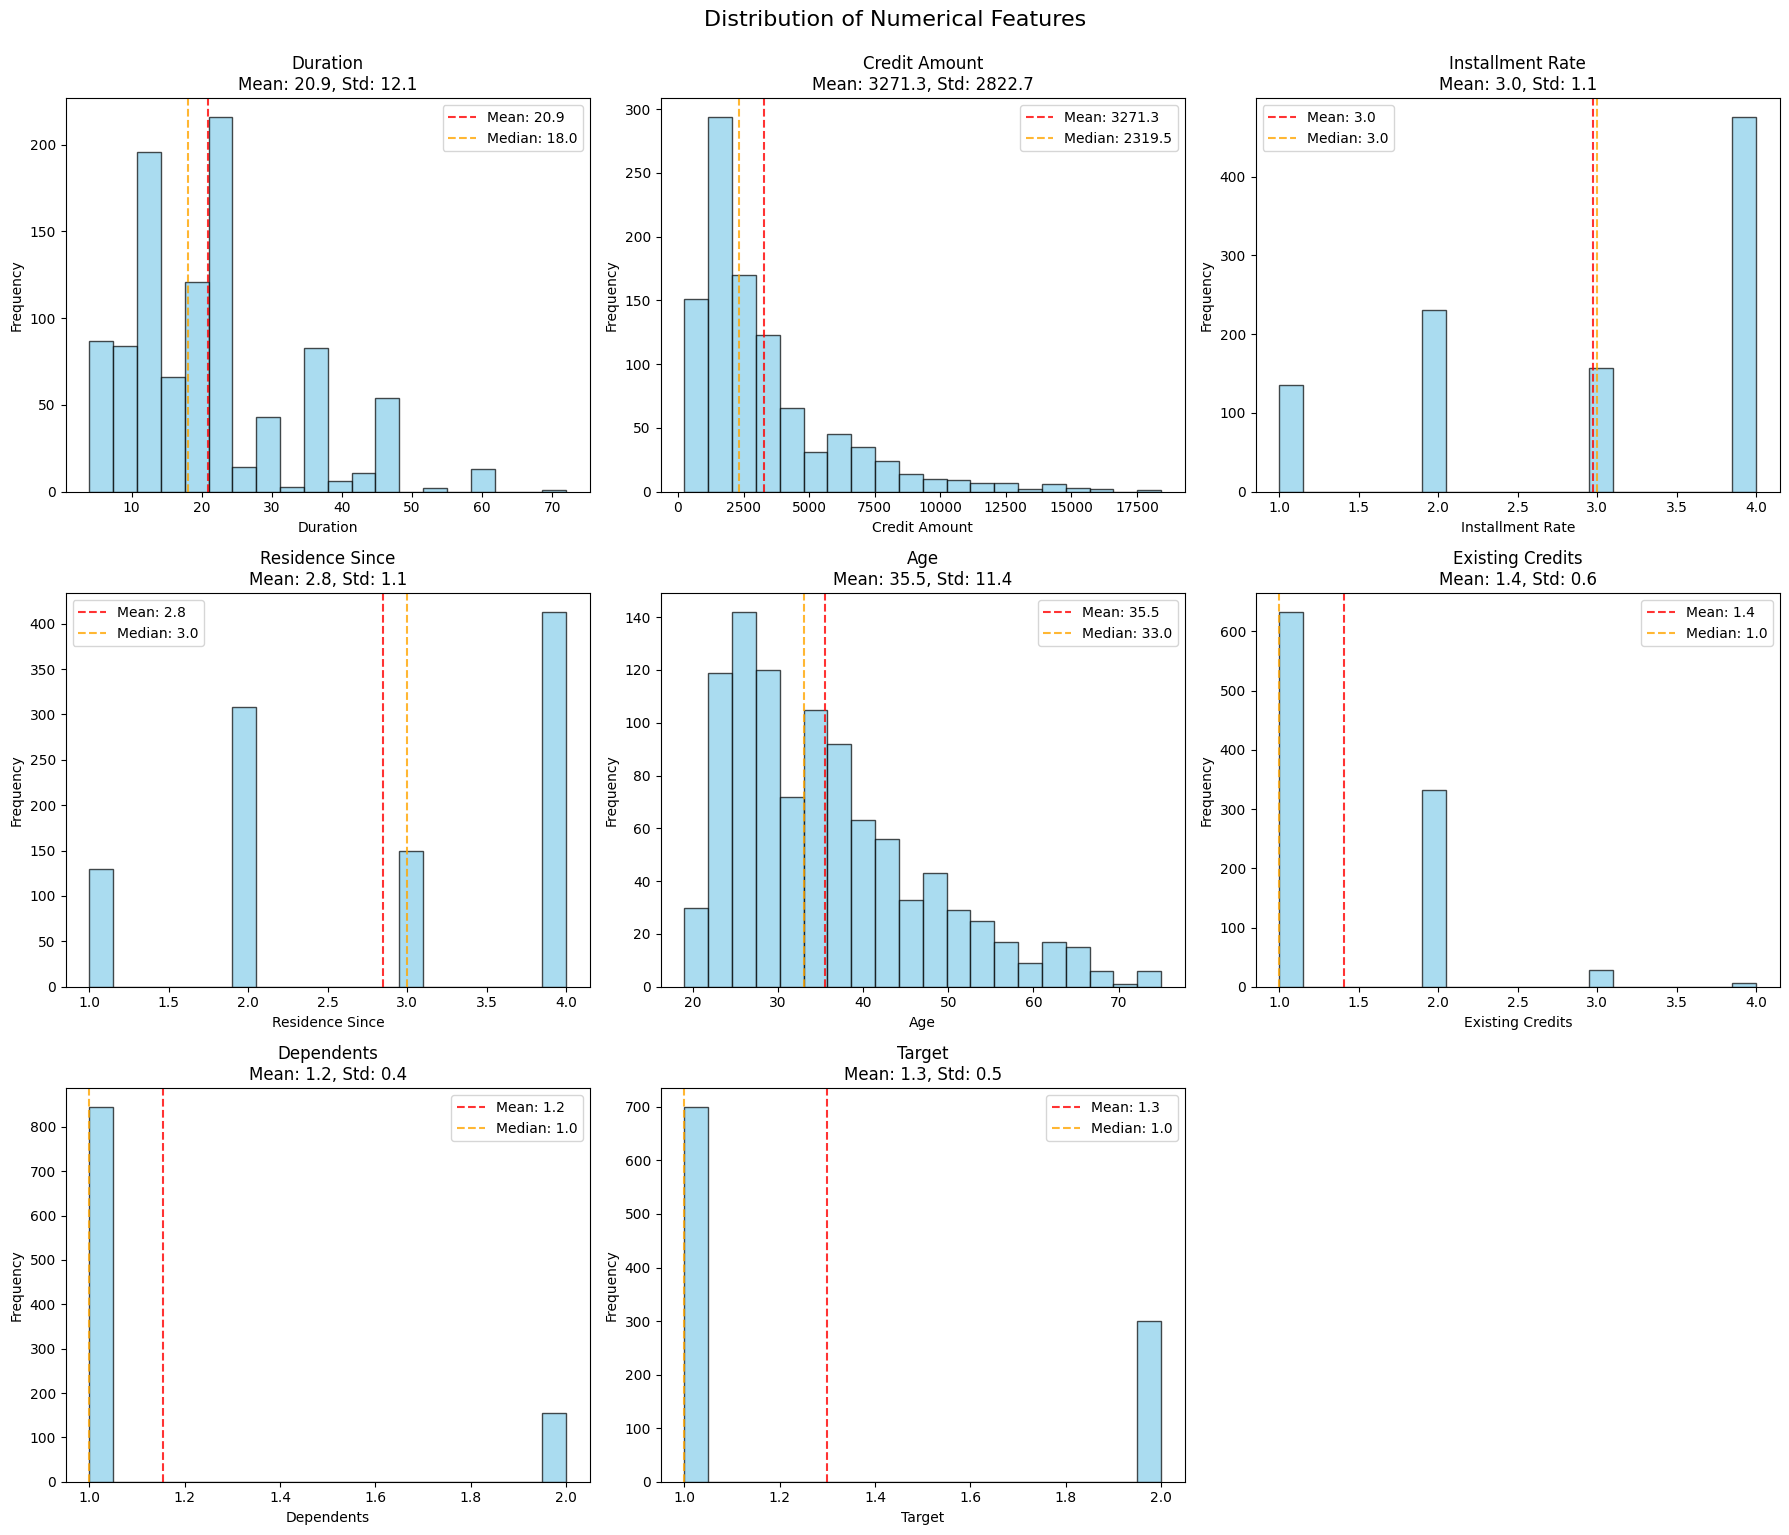

In [48]:
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    if i < len(axes):
        ax = axes[i]

        # Handle missing values for visualization
        feature_data = data[feature].dropna()

        # Histogram
        ax.hist(feature_data, bins=20, alpha=0.7, color='Skyblue', edgecolor='black')
        ax.set_title(f'{feature.replace("_", " ").title()}\nMean: {feature_data.mean():.1f}, Std: {feature_data.std():.1f}')
        ax.set_xlabel(feature.replace('_', ' ').title())
        ax.set_ylabel('Frequency')

        # Add statistics
        ax.axvline(feature_data.mean(), color='red', linestyle='--', alpha=0.8, label=f'Mean: {feature_data.mean():.1f}')
        ax.axvline(feature_data.median(), color='orange', linestyle='--', alpha=0.8, label=f'Median: {feature_data.median():.1f}')
        ax.legend()

# Remove empty subplots
for i in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.suptitle('Distribution of Numerical Features', y=1.02, fontsize=16)
plt.show()

## Visualize categorical feature distributions

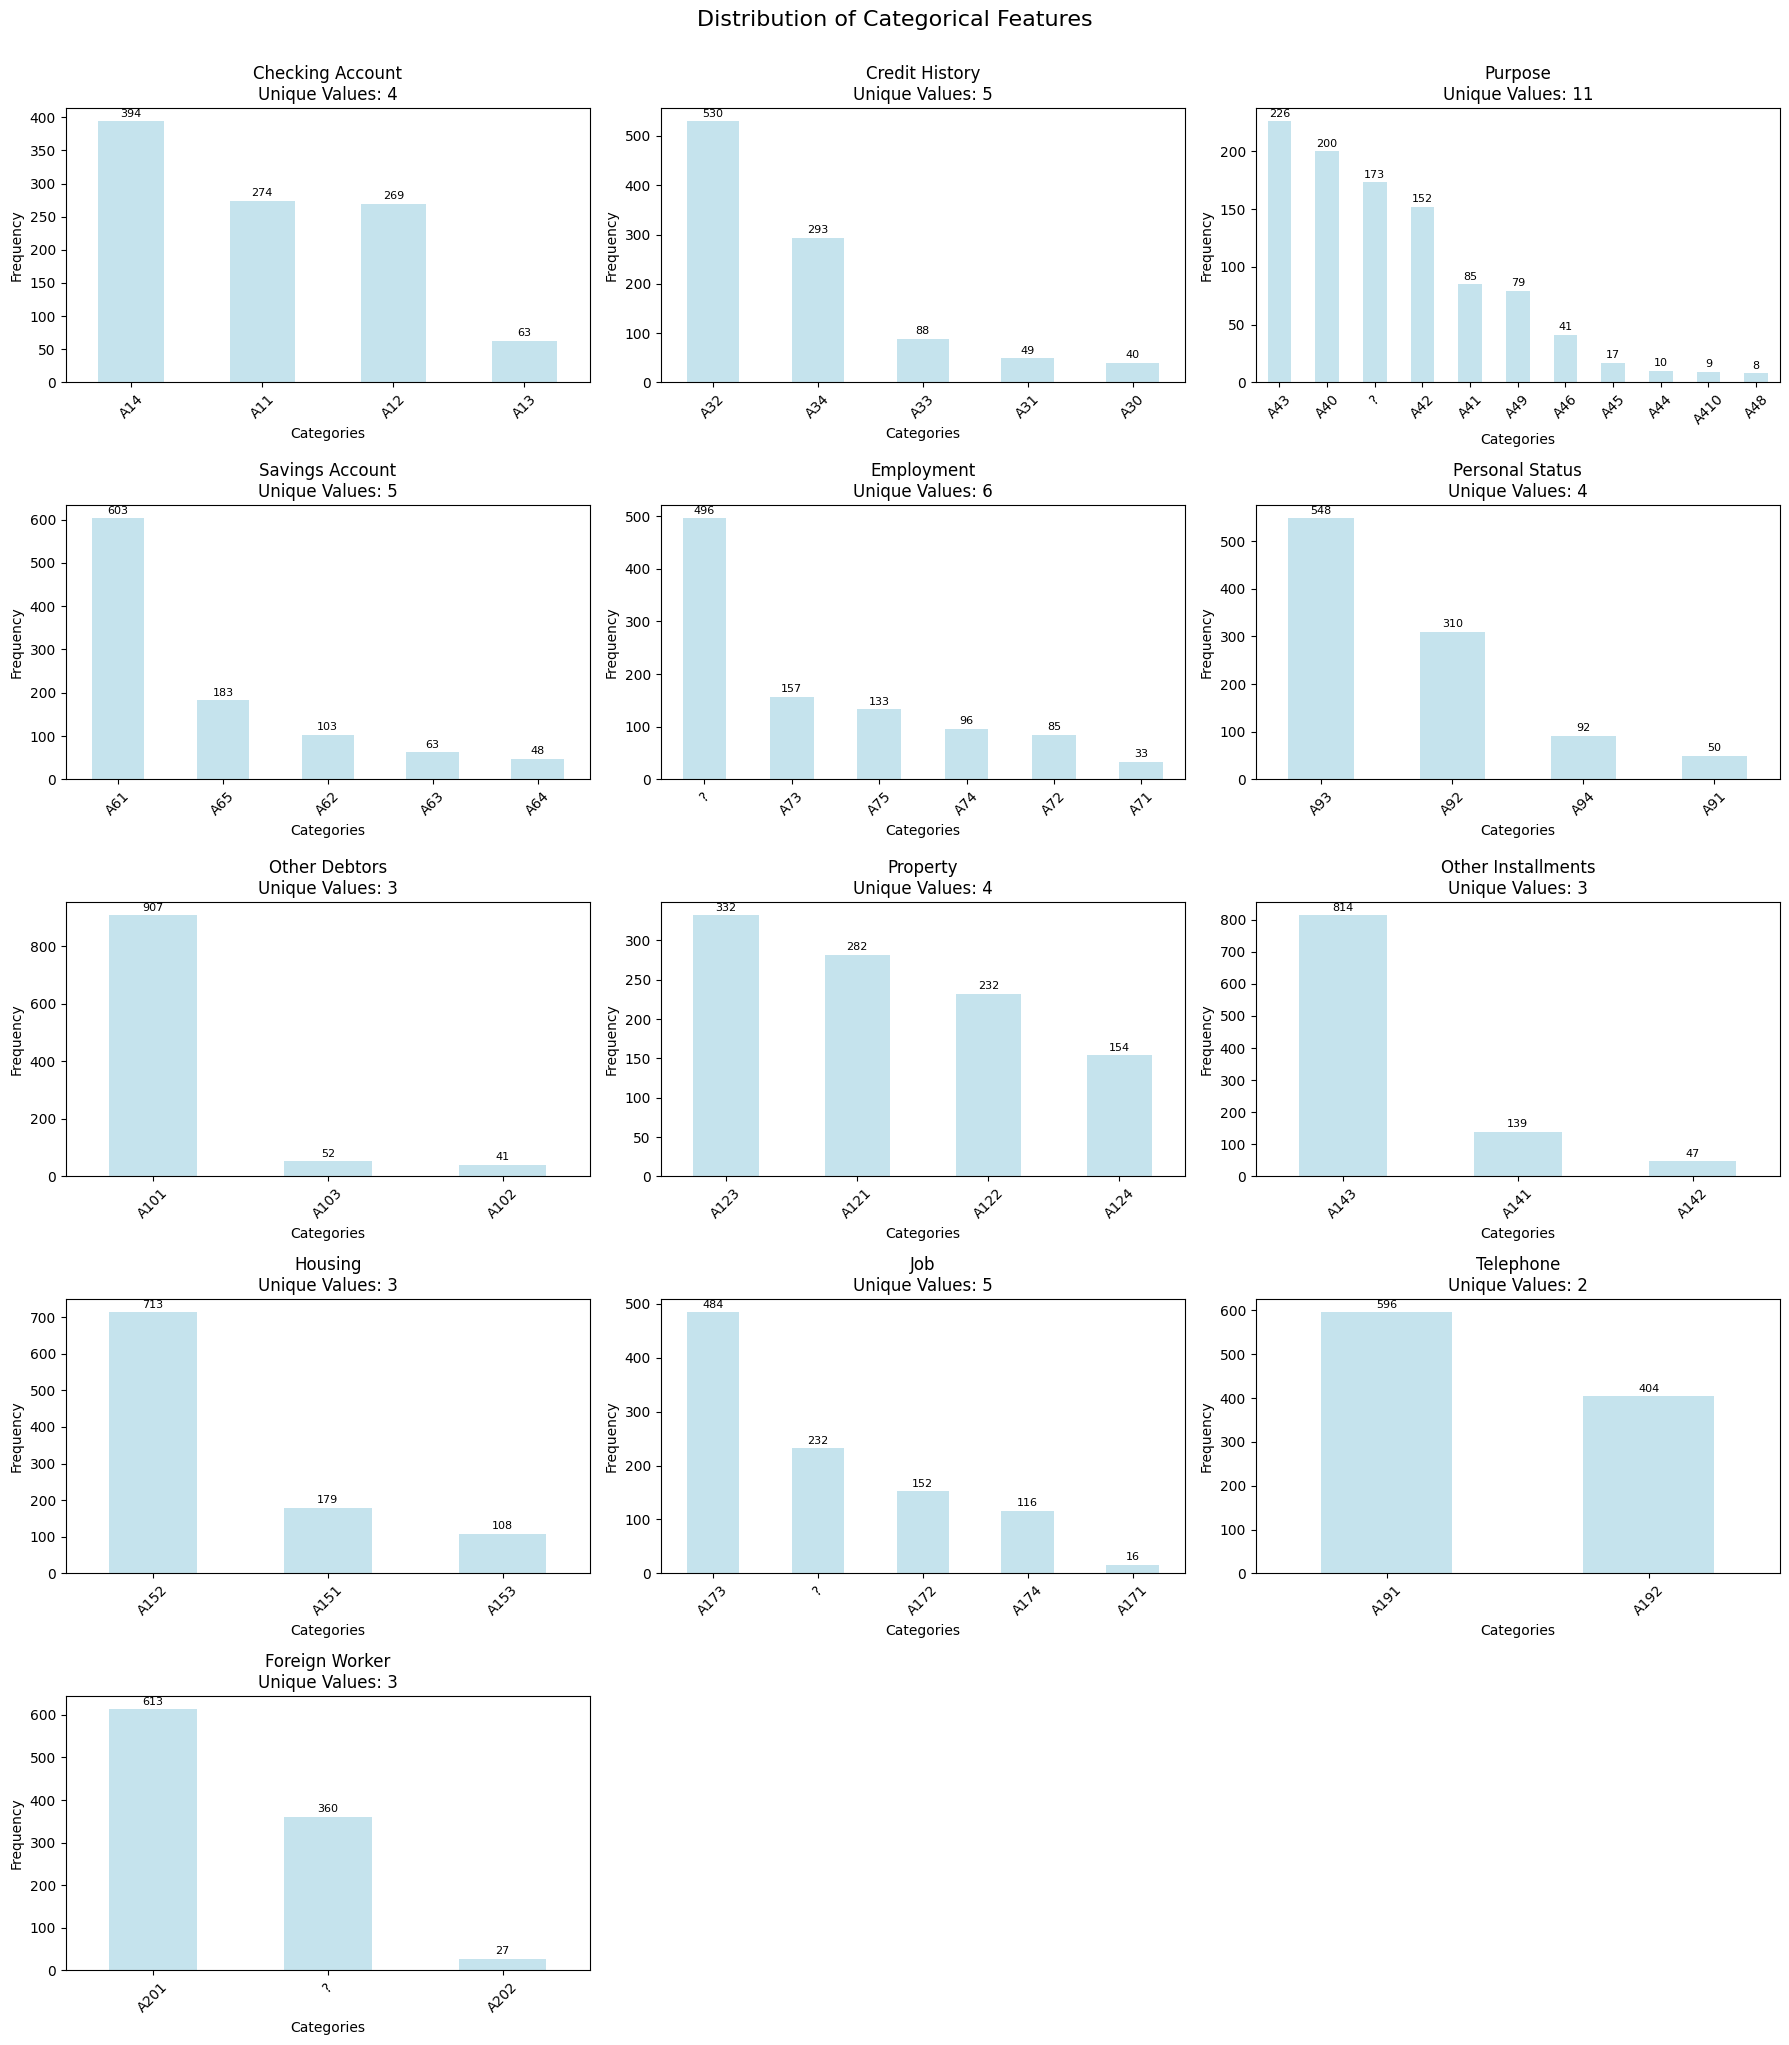

In [49]:
n_categorical = len(categorical_features)
n_cols = 3
n_rows = (n_categorical + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    if i < len(axes):
        ax = axes[i]

        # Count values including missing
        feature_counts = data[feature].fillna('Missing').value_counts()

        # Bar plot
        feature_counts.plot(kind='bar', ax=ax, color='lightblue', alpha=0.7)
        ax.set_title(f'{feature.replace("_", " ").title()}\nUnique Values: {data[feature].nunique()}')
        ax.set_xlabel('Categories')
        ax.set_ylabel('Frequency')
        ax.tick_params(axis='x', rotation=45)

        # Add value counts on bars
        for j, (category, count) in enumerate(feature_counts.items()):
            ax.text(j, count + max(feature_counts) * 0.01, str(count),
                   ha='center', va='bottom', fontsize=8)

# Remove empty subplots
for i in range(len(categorical_features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.suptitle('Distribution of Categorical Features', y=1.02, fontsize=16)
plt.show()

## Relationship Analysis of Categorical Features with Target

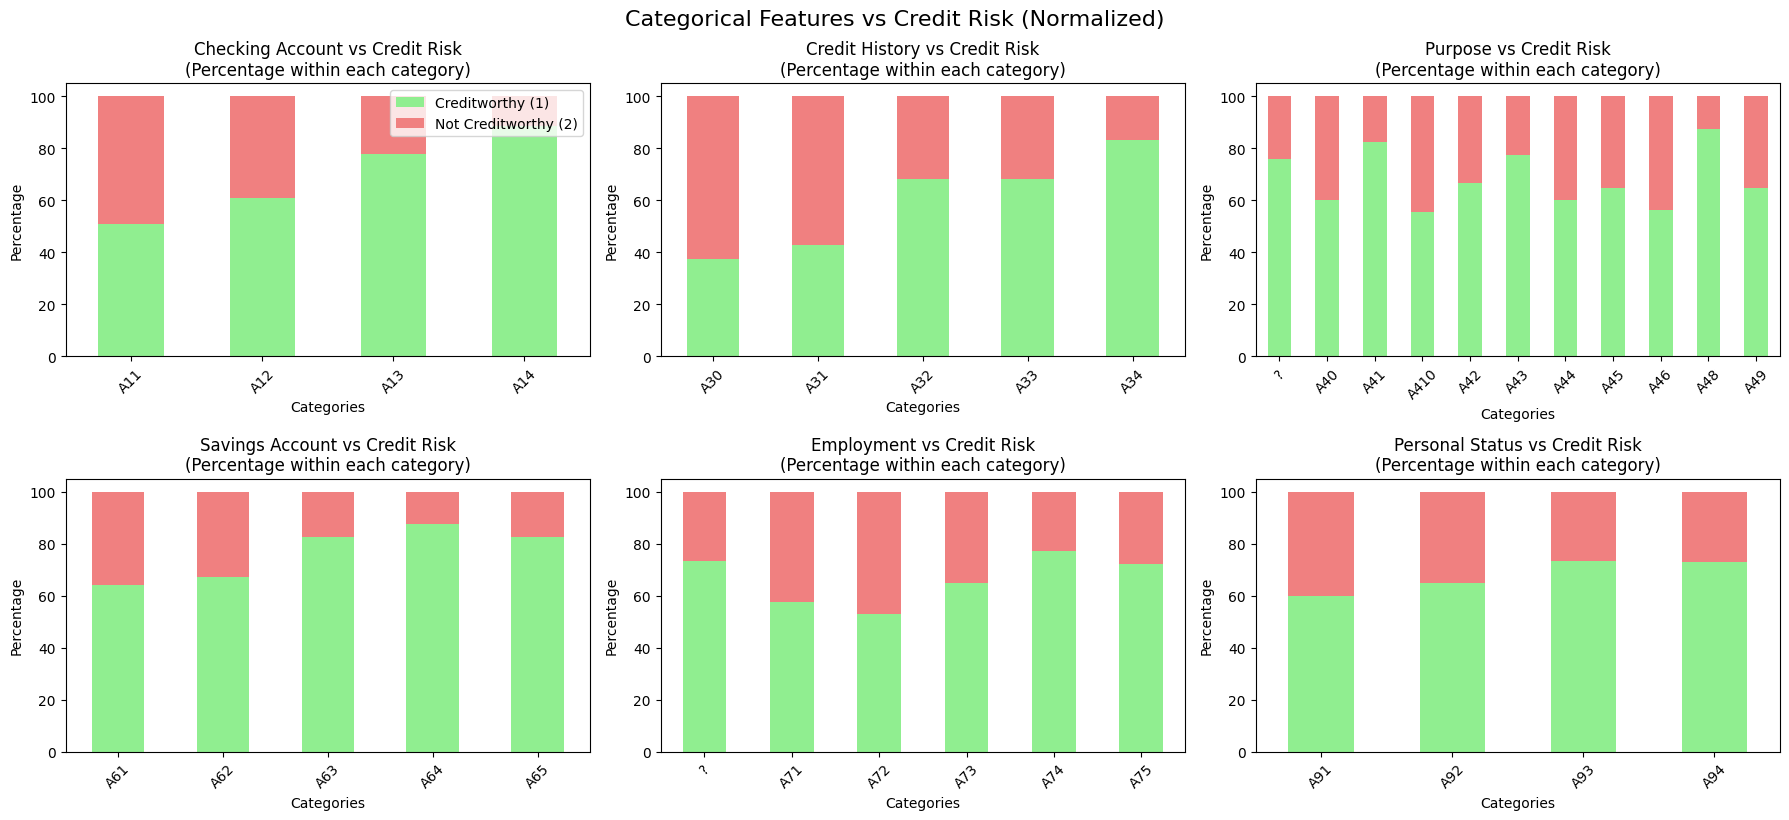

In [50]:
fig, axes = plt.subplots(2, 3, figsize=(18,8))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    if i < len(axes):
        ax = axes[i]

        # Create stacked bar chart
        cross_tab = pd.crosstab(data[feature].fillna('Missing'), data['target'], normalize='index') * 100

        cross_tab.plot(kind='bar', stacked=True, ax=ax,
                      color=['lightgreen', 'lightcoral'],
                      legend=False if i != 0 else True)

        ax.set_title(f'{feature.replace("_", " ").title()} vs Credit Risk\n(Percentage within each category)')
        ax.set_xlabel('Categories')
        ax.set_ylabel('Percentage')
        ax.tick_params(axis='x', rotation=45)

        if i == 0:
            ax.legend(['Creditworthy (1)', 'Not Creditworthy (2)'], loc='upper right')

plt.tight_layout()
plt.suptitle('Categorical Features vs Credit Risk (Normalized)', y=1.02, fontsize=16)
plt.show()

## Key Insights


Preprocessing
- Missing value: All the missing values belong to categorical features, so we will use linear classification to impute them as per mentioned in the instruction
- Numerical value: Though there are 7 numerical columns, only duration, credit amount and age contains a range of continuous values, and they are right skewed, so we will use log scaling
- Categorical value: Except checking account, no categorical values have ordinal vales based on our data plotted in replationship analysis with target variable, so we will convert all of them using one-hot encoding.

Model Selection
- We will use Logistic Regression as baseline model, then train other models like decision tree, random forest, feed forward neural network
- Class imbalance: 700 creditworthy vs 300 not creditworthy, so we need to use class_weight='balanced' in all prediction models
- Cost Sensitive nature: False positives cost 5x more than False negatives, so we will use Precision as scoring while hyperparameter tuning
- We will use nested cross validation as the dataset is small

Evaluation
- For evaluation, we will calculate the total cost,
- visulaize precision recall curve
- confusion matrix

# Data Preprocessing

In [51]:
# removing target variable from the dataset and replacing 2 as 0 for the simplicity of the calculation
data.target.replace([1,2], [1,0], inplace=True)

# For more convenient operations for missing values, replace '?' with 'NaN'
data.replace("?", np.nan, inplace=True)

label = data['target']
df_new = data.drop(columns=['target'])

print(df_new.shape)
print(f'Number of Missing Values\n{df_new.isnull().sum()}')

(1000, 20)
Number of Missing Values
checking_account        0
duration                0
credit_history          0
purpose               173
credit_amount           0
savings_account         0
employment            496
installment_rate        0
personal_status         0
other_debtors           0
residence_since         0
property                0
age                     0
other_installments      0
housing                 0
existing_credits        0
job                   232
dependents              0
telephone               0
foreign_worker        360
dtype: int64


## Handling Missing Values

In [52]:
def impute_missing_values(data, missing_features_df):
  data_imputed = data.copy()
  missing_features_list = missing_features_df["Feature"].tolist()


  for feature in missing_features_list:
    complete_mask = data_imputed[feature].notna()
    incomplete_mask = data_imputed[feature].isna()


    predictor_cols = [col for col in data_imputed.columns if col != feature]
    X_train = data_imputed.loc[complete_mask, predictor_cols]
    y_train = data_imputed.loc[complete_mask, feature]
    X_predict = data_imputed.loc[incomplete_mask, predictor_cols]


    # Simple mode imputation for predictors with missing values
    for col in predictor_cols:
      if X_train[col].dtype == "object":
        mode_val = X_train[col].mode().iloc[0]
        X_train[col] = X_train[col].fillna(mode_val)
        X_predict[col] = X_predict[col].fillna(mode_val)


    # One-hot encode categorical predictors
    cat_cols = [c for c in X_train.columns if X_train[c].dtype == "object"]
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    encoder.fit(pd.concat([X_train[cat_cols], X_predict[cat_cols]]))

    X_train_enc = encoder.transform(X_train[cat_cols])
    X_predict_enc = encoder.transform(X_predict[cat_cols])

    X_train_final = np.hstack([X_train.drop(columns=cat_cols).to_numpy(), X_train_enc])
    X_predict_final = np.hstack([X_predict.drop(columns=cat_cols).to_numpy(), X_predict_enc])

    # Train model for imputation
    model = LogisticRegression(
      multi_class="multinomial" if len(np.unique(y_train)) > 2 else "auto",
      class_weight="balanced",
      random_state=42,
      max_iter=1000
    )
    model.fit(X_train_final, y_train)
    y_pred = model.predict(X_predict_final)


    data_imputed.loc[incomplete_mask, feature] = y_pred

  return data_imputed

In [53]:
data_imputed = impute_missing_values(df_new, missing_features)

In [54]:
# Check for missing values in the imputed data
print(f'Number of Missing Values\n{data_imputed.isnull().sum()}')
data_imputed.head()

Number of Missing Values
checking_account      0
duration              0
credit_history        0
purpose               0
credit_amount         0
savings_account       0
employment            0
installment_rate      0
personal_status       0
other_debtors         0
residence_since       0
property              0
age                   0
other_installments    0
housing               0
existing_credits      0
job                   0
dependents            0
telephone             0
foreign_worker        0
dtype: int64


,checking_account,duration,credit_history,purpose,credit_amount,savings_account,employment,installment_rate,personal_status,other_debtors,residence_since,property,age,other_installments,housing,existing_credits,job,dependents,telephone,foreign_worker
0,A14,36,A32,A44,2299,A63,A74,4,A93,A101,4,A123,39,A143,A152,1,A173,1,A191,A201
1,A12,18,A32,A46,1239,A65,A73,4,A93,A101,4,A124,61,A143,A153,1,A172,1,A191,A201
2,A13,24,A32,A40,947,A61,A74,4,A93,A101,3,A124,38,A141,A153,1,A172,2,A191,A201
3,A14,15,A33,A43,1478,A61,A73,4,A94,A101,3,A121,33,A141,A152,2,A173,1,A191,A201
4,A14,24,A32,A40,1525,A64,A74,4,A92,A101,3,A123,34,A143,A152,1,A173,2,A192,A201


## Feature Representation

Now, we have a dataset with no missing values. Before starting model training, we now need to normalize the features.

### Numerical Features


In [55]:
def scale_numeric(data, numeric_cols):
    """
    Apply log scaling followed by standard scaling to numeric features.

    Parameters:
    -----------
    data : pd.DataFrame
        Input dataframe
    numeric_cols : list of str
        List of numeric feature names to scale

    Returns:
    --------
    pd.DataFrame
        Dataframe with scaled numeric features (other columns untouched)
    """
    df_scaled = data.copy()

    # Define pipeline for log transform + standard scaling
    scaler = Pipeline([
        ("log", FunctionTransformer(lambda x: np.log1p(np.maximum(x, 0)), validate=False)),
        ("scale", StandardScaler())
    ])

    # Apply transformation
    data_scaled = scaler.fit_transform(data[numeric_cols])

    # Replace numeric columns with scaled values
    df_scaled[numeric_cols] = pd.DataFrame(data_scaled, columns=numeric_cols, index=data.index)

    return df_scaled

### Categorical Features


In [56]:
def binary_encoding(data, binary_mappings):
    """
    Apply binary encoding to specified categorical features.

    Parameters:
    -----------
    data : pd.DataFrame
        Input dataframe
    binary_mappings : dict
        Mapping of {column_name: {category_value: binary_value, ...}}
    Returns:
    --------
    pd.DataFrame
        Dataframe with binary encoded features and original columns dropped
    """
    data_binary = data.copy()

    for col, mapping in binary_mappings.items():
        new_col = f"{col}_binary"
        data_binary[new_col] = data_binary[col].map(mapping).astype(int)
        data_binary = data_binary.drop(columns=[col])

    return data_binary

In [57]:
def onehot_encoding(data, categorical_cols):
    """
    Apply one-hot encoding to categorical features.

    Parameters:
    -----------
    data : pd.DataFrame
        Input dataframe
    categorical_cols : list of str
        List of categorical feature names to encode

    Returns:
    --------
    pd.DataFrame
        Dataframe containing only the encoded categorical features
    """
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

    # Fit + transform categorical features
    data_encoded = encoder.fit_transform(data[categorical_cols])

    # Extract column names
    encoded_cols = encoder.get_feature_names_out(categorical_cols)

    # Return as dataframe
    df_encoded = pd.DataFrame(data_encoded, columns=encoded_cols, index=data.index)

    return df_encoded

## Preprocess dataset
Among all the numerical features only duration, credit amount, and age have continuous range of values, and they all are right skewed. Other numerical features contains discrete values, so we will treat them as categorical and only normalize the features with continuos values.

From our initial EDA, we can see except one categorical feature, no other has any ordinal meaning. So we will convert them using one hot encoding. There are two features telephone, and foreign worker which contains string values but represents yes/no, so we will convert those two into 0/1.

In [58]:
# Step 1: scale numeric
numeric_cols = ["duration", "credit_amount", "age"]
df_scaled = scale_numeric(data_imputed, numeric_cols)

# Step 2: binary encode
binary_mappings = {
    "telephone": {"A191": 0, "A192": 1},
    "foreign_worker": {"A201": 1, "A202": 0}
}
df_binary = binary_encoding(df_scaled, binary_mappings)

# Step 3: one-hot encode
categorical_cols = [col for col in df_binary.columns if df_binary[col].dtype == 'object']
df_encoded = onehot_encoding(df_binary, categorical_cols)

# Final combined dataframe
df_final = pd.concat([df_binary.drop(columns=categorical_cols), df_encoded], axis=1)

df_final.info()
df_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 59 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   duration                 1000 non-null   float64
 1   credit_amount            1000 non-null   float64
 2   installment_rate         1000 non-null   int64  
 3   residence_since          1000 non-null   int64  
 4   age                      1000 non-null   float64
 5   existing_credits         1000 non-null   int64  
 6   dependents               1000 non-null   int64  
 7   telephone_binary         1000 non-null   int64  
 8   foreign_worker_binary    1000 non-null   int64  
 9   checking_account_A11     1000 non-null   float64
 10  checking_account_A12     1000 non-null   float64
 11  checking_account_A13     1000 non-null   float64
 12  checking_account_A14     1000 non-null   float64
 13  credit_history_A30       1000 non-null   float64
 14  credit_history_A31       

,duration,credit_amount,installment_rate,residence_since,age,existing_credits,dependents,telephone_binary,foreign_worker_binary,checking_account_A11,...,other_installments_A141,other_installments_A142,other_installments_A143,housing_A151,housing_A152,housing_A153,job_A171,job_A172,job_A173,job_A174
0,1.226830,-0.062627,4,4,0.461116,1,1,0,1,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.006404,-0.859081,4,4,1.965742,1,1,0,1,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.508940,-1.205241,4,3,0.374195,1,2,0,1,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,-0.308280,-0.631856,4,3,-0.096847,2,1,0,1,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.508940,-0.591526,4,3,0.002674,1,2,1,1,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


# Model Training

## Dataset Splitting

In [59]:
X_train, X_test, y_train, y_test = train_test_split(df_final, label, test_size = 0.25, random_state=42)

print(f'X train',X_train.shape)
print(f'X test',X_test.shape)
print(f'y train',y_train.shape)
print(f'y test',y_test.shape)

X train (750, 59)
X test (250, 59)
y train (750,)
y test (250,)


## Nested Cross-Validation

In [60]:
def nested_cross_validation(clf, param_grid, X, y, outer_splits=5, inner_splits=5):
    """
    Nested cross-validation with cost-sensitive evaluation.

    Parameters
    ----------
    clf : sklearn estimator
        Classifier to evaluate
    param_grid : dict
        Hyperparameter grid for inner CV search
    X : pd.DataFrame
        Feature matrix
    y : pd.Series
        Target labels
    outer_splits : int, default=5
        Number of outer CV folds
    inner_splits : int, default=5
        Number of inner CV folds

    Returns
    -------
    fold_results : list of dict
        Metrics and best params for each outer fold
    common_params : dict
        Most frequently chosen hyperparameters across folds
    """

    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=42)

    fold_results = []
    best_params_per_fold = []

    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        # Split data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Inner CV for hyperparameter tuning
        inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=42)
        grid = GridSearchCV(clf, param_grid, cv=inner_cv, scoring="precision", n_jobs=-1)
        grid.fit(X_train, y_train)

        best_params = grid.best_params_
        best_params_per_fold.append(best_params)
        best_model = grid.best_estimator_

        # Predictions on test fold
        y_pred = best_model.predict(X_test)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        cost = fp * 5 + fn * 1

        # Store fold metrics
        metrics = {
            "fold": fold_idx + 1,
            "cost": cost,
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred),
            "roc_auc": roc_auc_score(y_test, y_pred),
            "best_params": best_params
        }
        fold_results.append(metrics)

        print(f"Fold {metrics['fold']}: Cost={metrics['cost']}, Params={metrics['best_params']}")

    # Find most common parameters across folds
    common_params = {}
    for param in param_grid:
        values = [bp[param] for bp in best_params_per_fold]
        common_params[param] = Counter(values).most_common(1)[0][0]

    print("\nMost common parameters across folds:", common_params)

    return fold_results, common_params

# Logistic Regression
This is our baseline model

In [61]:
def hyperParameterTuning_LogisticRegression(features, labels):
  params = {
      "C": [0.01, 0.1, 1.0, 10.0, 100.0],
      "penalty": ["l1", "l2"],
      "solver": ["liblinear", "saga"],
      "class_weight": ["balanced"],
      "random_state": [42]
  }

  lr_model = LogisticRegression()
  X, y = features, labels

  fold_results, best_params = nested_cross_validation(lr_model, params, X, y)

  return fold_results, best_params

In [62]:
lr_fold_results, lr_best_params = hyperParameterTuning_LogisticRegression(X_train, y_train)

Fold 1: Cost=78, Params={'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 42, 'solver': 'saga'}
Fold 2: Cost=83, Params={'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 42, 'solver': 'saga'}
Fold 3: Cost=104, Params={'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear'}
Fold 4: Cost=104, Params={'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear'}
Fold 5: Cost=92, Params={'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear'}

Most common parameters across folds: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear', 'class_weight': 'balanced', 'random_state': 42}


In [63]:
logreg_model = LogisticRegression(**lr_best_params)
logreg_model

,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.1
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


# Decision Tree

In [64]:
def hyperParameterTuning_DecisionTree(features, labels):
  params = {
      "max_depth": [2, 5, 10],
      "min_samples_split": [20, 50, 100],
      "min_samples_leaf": [10, 20, 50],
      "criterion": ["gini", "entropy"],
      "class_weight": ["balanced"],
      "random_state": [42]
  }

  dt_model = DecisionTreeClassifier()
  X, y = features, labels

  fold_results, best_params = nested_cross_validation(dt_model, params, X, y)

  return fold_results, best_params

In [65]:
dt_fold_results, dt_best_params = hyperParameterTuning_DecisionTree(X_train, y_train)

Fold 1: Cost=91, Params={'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 100, 'random_state': 42}
Fold 2: Cost=72, Params={'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 20, 'random_state': 42}
Fold 3: Cost=90, Params={'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 20, 'random_state': 42}
Fold 4: Cost=124, Params={'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 20, 'random_state': 42}
Fold 5: Cost=102, Params={'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 50, 'min_samples_split': 20, 'random_state': 42}

Most common parameters across folds: {'max_depth': 2, 'min_samples_split': 20, 'min_samples_leaf': 10, 'criterion': 'gini', 'class_weight': 'balanced', 'random_state': 42}


In [66]:
dt_model = DecisionTreeClassifier(**dt_best_params)
dt_model

,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,20
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


# Random Forest

In [67]:
def hyperParameterTuning_rf(features, labels):
    # Only tunable parameters in the grid
    params = {
        "n_estimators": [50, 100, 200],
        "max_depth": [2, 5, 10, 15],
        "min_samples_split": [10, 15, 20],
        "min_samples_leaf": [2, 5, 10],
        "class_weight": ["balanced", "balanced_subsample"],
        "criterion": ["gini", "entropy"],
        "random_state": [42],
        "n_jobs": [-1],
        "warm_start": [True]
    }

    # Fixed parameters passed to the model
    rf_model = RandomForestClassifier()

    X, y = features, labels
    fold_results, best_params = nested_cross_validation(rf_model, params, X, y)

    return fold_results, best_params

In [68]:
rf_fold_results, rf_best_params = hyperParameterTuning_rf(X_train, y_train)

Fold 1: Cost=77, Params={'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 42, 'warm_start': True}
Fold 2: Cost=77, Params={'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42, 'warm_start': True}
Fold 3: Cost=95, Params={'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 42, 'warm_start': True}
Fold 4: Cost=106, Params={'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 42, 'warm_start': True}
Fold 5: Cost=99, Params={'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples

In [69]:
rf_model = RandomForestClassifier(**rf_best_params)
rf_model

,n_estimators,50
,criterion,'gini'
,max_depth,2
,min_samples_split,10
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


# Feedforward Neural Network

In [90]:
# Neural Network imports
from keras.models import Sequential
from keras import metrics
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
import numpy as np

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

def create_binary_nn_model(input_dim, hidden_units=64, dropout_rate=0.3, learning_rate=0.001):
    """
    Create a binary classification neural network model.
    
    Parameters:
    - input_dim: Number of input features
    - hidden_units: Number of neurons in first hidden layer
    - dropout_rate: Dropout rate for regularization
    - learning_rate: Learning rate for optimizer
    """
    model = Sequential()
    
    # First hidden layer with batch normalization
    model.add(Dense(hidden_units, input_dim=input_dim))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))
    
    # Second hidden layer
    model.add(Dense(hidden_units // 2))
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))
    
    # Output layer for binary classification
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model - CHANGED: Added recall to balance with precision
    #model.compile(
    #    loss='binary_crossentropy',
    #    optimizer=Adam(learning_rate=learning_rate),
    #    metrics=['precision']
    #)

    metrics = [
        metrics.FalseNegatives(name="fn"),
        metrics.FalsePositives(name="fp"),
        metrics.TrueNegatives(name="tn"),
        metrics.TruePositives(name="tp"),
        metrics.Precision(name="precision"),
        metrics.Recall(name="recall"),
    ]

    model.compile(
        optimizer=Adam(learning_rate=learning_rate), loss="binary_crossentropy", metrics=metrics
    )
        
    return model



class NNWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, hidden_units=64, dropout_rate=0.3, learning_rate=0.001, epochs=100, 
                 batch_size=32, threshold=0.5, patience=10, fp_cost=5, fn_cost=1):
        self.hidden_units = hidden_units
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.threshold = threshold
        self.patience = patience
        self.fp_cost = fp_cost  # NEW
        self.fn_cost = fn_cost  # NEW

    def fit(self, X, y):
        """
        Fit the neural network model.
        """
        self.classes_ = np.unique(y)
        
        if not hasattr(self, 'model') or self.model is None:
            self.model = create_binary_nn_model(
                X.shape[1], self.hidden_units, self.dropout_rate, self.learning_rate
            )
        
        # CHANGED: Adjust class weights for cost ratio
        class_weights = compute_class_weight('balanced', classes=self.classes_, y=y)
        # Boost positive class weight to reduce false negatives
        class_weight = {
            0: class_weights[0] * self.fp_cost,
            1: class_weights[1] * self.fn_cost
        }

        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=self.patience,
                restore_best_weights=True,
                verbose=0
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=self.patience//2,
                min_lr=1e-6,
                verbose=0
            )
        ]
        
        self.history = self.model.fit(
            X, y, 
            epochs=self.epochs, 
            batch_size=self.batch_size,
            class_weight=class_weight,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=0
        )
        
        return self
        
    def predict(self, X):
        """Make binary predictions using hyperparameter-tuned threshold."""
        probabilities = self.model.predict(X, batch_size=self.batch_size, verbose=0)
        # Use hyperparameter-tuned threshold
        return (probabilities > self.threshold).astype(int).flatten()

    def predict_proba(self, X):
        """Return prediction probabilities for both classes."""
        proba_class_1 = self.model.predict(X, batch_size=self.batch_size, verbose=0).flatten()
        proba_class_0 = 1 - proba_class_1
        return np.column_stack([proba_class_0, proba_class_1])

In [91]:
def hyperParameterTuning_NeuralNetwork(features, labels):
    """Hyperparameter tuning for Neural Network"""
    params = {
        "hidden_units": [32, 64],
        "dropout_rate": [0.3, 0.4],
        "learning_rate": [0.001, 0.01],
        "epochs": [30, 50],
        "batch_size": [32, 64],
        "threshold": [0.7, 0.8]
    }
    
    nn_model = NNWrapper()
    X, y = features, labels
    fold_results, best_params = nested_cross_validation(nn_model, params, X, y)
    
    return fold_results, best_params

In [92]:
# Run hyperparameter tuning
nn_fold_results, nn_best_params = hyperParameterTuning_NeuralNetwork(X_train, y_train)

ValueError: 
All the 320 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\lamia\Documents\DS Study\ML\Project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lamia\AppData\Local\Temp\ipykernel_13016\2742015210.py", line 85, in fit
  File "C:\Users\lamia\AppData\Local\Temp\ipykernel_13016\2742015210.py", line 49, in create_binary_nn_model
UnboundLocalError: cannot access local variable 'metrics' where it is not associated with a value


In [85]:
nn_model = NNWrapper(**nn_best_params)
nn_model

,hidden_units,64
,dropout_rate,0.3
,learning_rate,0.01
,epochs,50
,batch_size,32
,threshold,0.7
,patience,10
,fp_cost,5
,fn_cost,1


# Model Evaluation

In [74]:
def calculate_metrics(y_true, y_pred):
    """Calculate all evaluation metrics"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1_score': f1_score(y_true, y_pred, zero_division=0),
        'cost': fp * 5 + fn * 1,  # FP costs 5x more than FN
        'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp
    }
    return metrics

In [75]:
def evaluate_all_models(models_dict, X_train, X_test, y_train, y_test):
    """
    Evaluate all models on both training and test sets.
    
    Parameters:
    -----------
    models_dict : dict
        Dictionary with model names as keys and model objects as values
    X_train, X_test : pd.DataFrame
        Training and test feature sets
    y_train, y_test : pd.Series
        Training and test target sets
    
    Returns:
    --------
    results_df : pd.DataFrame
        Comprehensive evaluation results for all models
    """
    
    results = []
    
    
    # Create subplots for confusion matrices
    n_models = len(models_dict)
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 5))
    
    for idx, (model_name, model) in enumerate(models_dict.items()):
        print(f"\n{model_name.upper()}")
        print("-" * 50)
        
        # Fit model on training data
        model.fit(X_train, y_train)
        
        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Calculate metrics for training set
        train_metrics = calculate_metrics(y_train, y_train_pred)
        
        # Calculate metrics for test set
        test_metrics = calculate_metrics(y_test, y_test_pred)
        
        # Store results
        result = {
            'Model': model_name,
            'Train_Accuracy': train_metrics['accuracy'],
            'Train_Precision': train_metrics['precision'],
            'Train_Recall': train_metrics['recall'],
            'Train_F1': train_metrics['f1_score'],
            'Train_Cost': train_metrics['cost'],
            'Test_Accuracy': test_metrics['accuracy'],
            'Test_Precision': test_metrics['precision'],
            'Test_Recall': test_metrics['recall'],
            'Test_F1': test_metrics['f1_score'],
            'Test_Cost': test_metrics['cost']
        }
        results.append(result)
        
        # Print results
        print(f"Training Metrics:")
        print(f"  Cost:      {train_metrics['cost']}")
        print(f"  Accuracy:  {train_metrics['accuracy']:.4f}")
        print(f"  Precision: {train_metrics['precision']:.4f}")
        print(f"  Recall:    {train_metrics['recall']:.4f}")
        print(f"  F1-Score:  {train_metrics['f1_score']:.4f}")
        
        
        print(f"Test Metrics:")
        print(f"  Cost:      {test_metrics['cost']}")
        print(f"  Accuracy:  {test_metrics['accuracy']:.4f}")
        print(f"  Precision: {test_metrics['precision']:.4f}")
        print(f"  Recall:    {test_metrics['recall']:.4f}")
        print(f"  F1-Score:  {test_metrics['f1_score']:.4f}")
        
        # Confusion matrix
        cm_test = confusion_matrix(y_test, y_test_pred)
        sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Not Creditworthy', 'Creditworthy'],
                   yticklabels=['Not Creditworthy', 'Creditworthy'],
                   ax=axes[idx])
        axes[idx].set_title(f'{model_name} - Test\nCost: {test_metrics["cost"]}')
        axes[idx].set_ylabel('True Label')
        axes[idx].set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()
    
    # Create results DataFrame
    results_df = pd.DataFrame(results)
    
    # Find best models
    print("Best model by metric")
    print("-" * 50)
    best_test_cost = results_df.loc[results_df['Test_Cost'].idxmin()]
    best_test_precision = results_df.loc[results_df['Test_Precision'].idxmax()]
    
    print(f"Lowest Test Cost:       {best_test_cost['Model']} (Cost: {best_test_cost['Test_Cost']})")
    print(f"Highest Test Precision: {best_test_precision['Model']} (Precision: {best_test_precision['Test_Precision']:.4f})")
    
    return results_df

In [86]:
def plot_model_comparison_curves(models_dict, X_test, y_test):
    """
    Plot Precision-Recall and ROC-AUC curves for all models.
    
    Parameters:
    -----------
    models_dict : dict
        Dictionary with model names as keys and fitted model objects as values
    X_test : pd.DataFrame
        Test feature set
    y_test : pd.Series
        Test target set
    """
    from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score
    
    # Set up the plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Colors for different models
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    for idx, (model_name, model) in enumerate(models_dict.items()):
        color = colors[idx % len(colors)]
        
        
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        
        # Calculate Precision-Recall curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        avg_precision = average_precision_score(y_test, y_pred_proba)
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        # Plot Precision-Recall curve
        ax1.plot(recall, precision, color=color, lw=2, 
                label=f'{model_name} (AP={avg_precision:.3f})')
        
        # Plot ROC curve
        ax2.plot(fpr, tpr, color=color, lw=2,
                label=f'{model_name} (AUC={roc_auc:.3f})')
        
        print(f"{model_name}:")
        print(f"  Average Precision: {avg_precision:.4f}")
        print(f"  ROC-AUC Score:     {roc_auc:.4f}")
        print()
    
    # Customize Precision-Recall plot
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_title('Precision-Recall Curves')
    ax1.legend(loc='lower left')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    
    # Add baseline for PR curve (random classifier)
    baseline_precision = sum(y_test) / len(y_test)
    ax1.axhline(y=baseline_precision, color='gray', linestyle='--', 
                label=f'Random Classifier (AP={baseline_precision:.3f})')
    ax1.legend(loc='lower left')
    
    # Customize ROC plot
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curves')
    ax2.legend(loc='lower right')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    
    # Add diagonal line for ROC (random classifier)
    ax2.plot([0, 1], [0, 1], color='gray', linestyle='--', 
             label='Random Classifier (AUC=0.500)')
    ax2.legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()

In [87]:
models = {
    'Logistic Regression': logreg_model,
    'Decision Tree': dt_model,
    'Random Forest': rf_model,
    'Neural Network': nn_model
}


LOGISTIC REGRESSION
--------------------------------------------------
Training Metrics:
  Cost:      378
  Accuracy:  0.7573
  Precision: 0.8914
  Recall:    0.7514
  F1-Score:  0.8154
Test Metrics:
  Cost:      160
  Accuracy:  0.6800
  Precision: 0.8400
  Recall:    0.6364
  F1-Score:  0.7241

DECISION TREE
--------------------------------------------------
Training Metrics:
  Cost:      434
  Accuracy:  0.6720
  Precision: 0.8773
  Recall:    0.6280
  F1-Score:  0.7320
Test Metrics:
  Cost:      177
  Accuracy:  0.6280
  Precision: 0.8158
  Recall:    0.5636
  F1-Score:  0.6667

RANDOM FOREST
--------------------------------------------------
Training Metrics:
  Cost:      418
  Accuracy:  0.7147
  Precision: 0.8794
  Recall:    0.6953
  F1-Score:  0.7766
Test Metrics:
  Cost:      161
  Accuracy:  0.6600
  Precision: 0.8390
  Recall:    0.6000
  F1-Score:  0.6996

NEURAL NETWORK
--------------------------------------------------
Training Metrics:
  Cost:      245
  Accuracy:  0.7

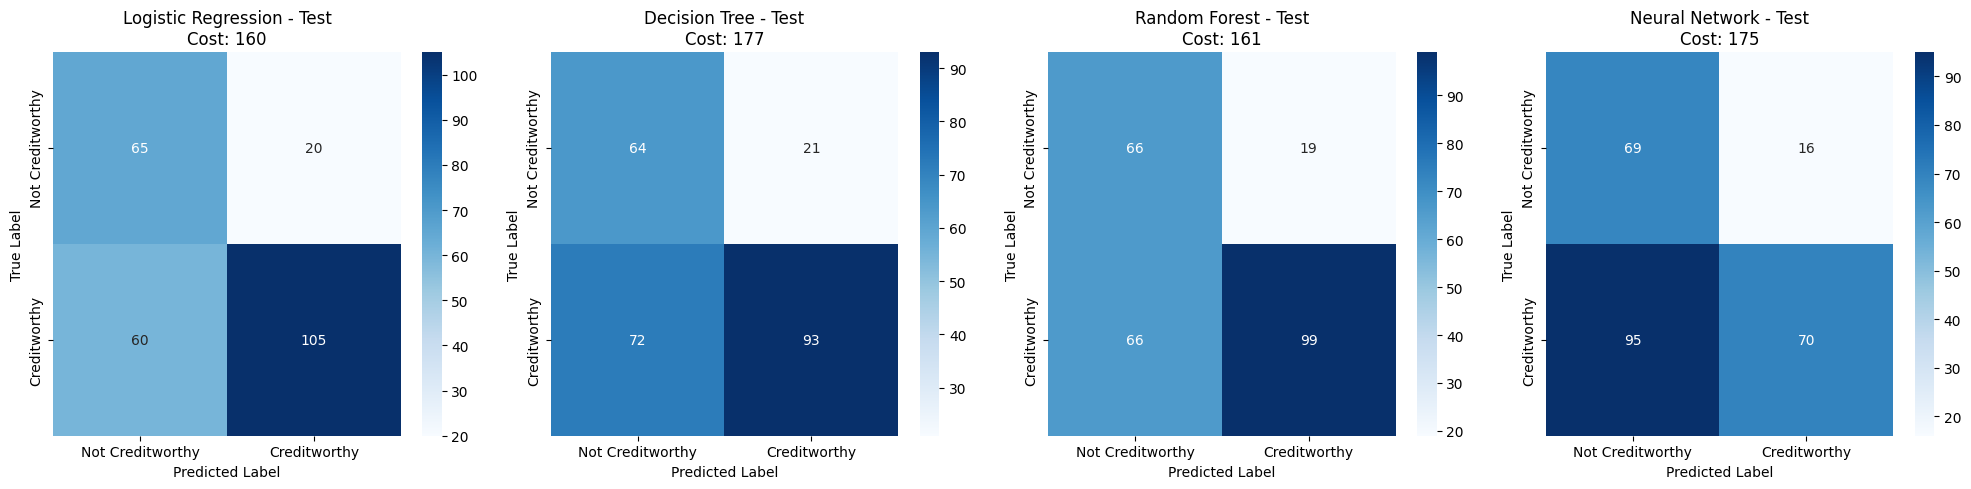

Best model by metric
--------------------------------------------------
Lowest Test Cost:       Logistic Regression (Cost: 160)
Highest Test Precision: Logistic Regression (Precision: 0.8400)


In [88]:
# Run evaluation
evaluation_results = evaluate_all_models(models, X_train, X_test, y_train, y_test)

Logistic Regression:
  Average Precision: 0.8517
  ROC-AUC Score:     0.7437

Decision Tree:
  Average Precision: 0.7741
  ROC-AUC Score:     0.6749

Random Forest:
  Average Precision: 0.8656
  ROC-AUC Score:     0.7491

Neural Network:
  Average Precision: 0.8043
  ROC-AUC Score:     0.6885



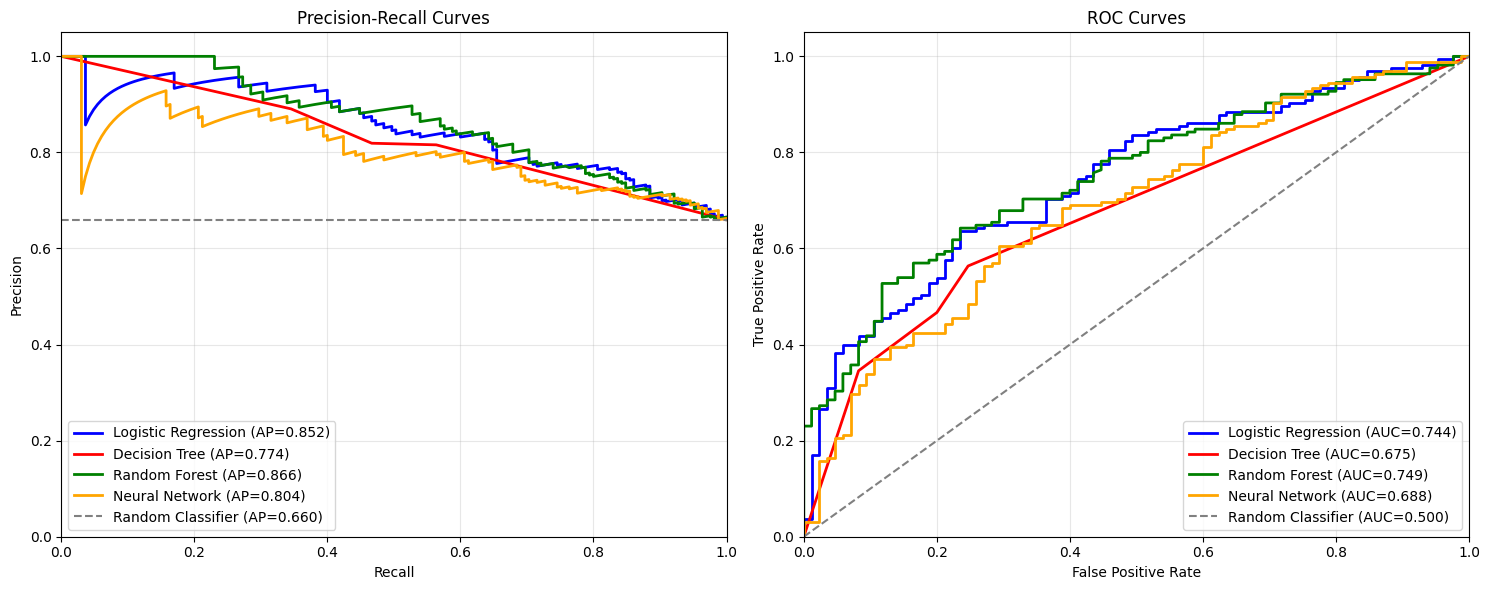

In [89]:
plot_model_comparison_curves(models, X_test, y_test)

Precision-Recall Curve:
  - Higher curves (towards top-right) are better
  - Average Precision (AP) summarizes the curve
  - Important for imbalanced datasets like credit risk

ROC Curve:
  - Higher curves (towards top-left) are better
  - AUC closer to 1.0 indicates better performance
  - AUC = 0.5 represents random guessing

For Credit Risk Assessment:
  - Focus more on Precision-Recall due to class imbalance
  - High precision reduces costly false positives
  - Balance precision and recall based on business needs